In [ ]:
#| default_exp basic

# Basic hydro functions

These are low level functions. The functions are not used directly to analyse performance but are often used as input values for functions

Functions in this module are

- kinamatic viscosity
- reynolds number
- Frictional resistance coefficient - ITTC 57
- Froude number
- roughness allowance 

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
import pandas as pd
from fastcore.test import *

## Dynamic viscosity

The dynamic viscosity of seawater can be found using the equations of [Sharkawy et al 2010](https://doi.org/10.5004/dwt.2010.1079). This equation is used in the TEOS-10 standard and is implemented here.

$$\mu_{SW} = \mu_W (1 + AS +BS^2)$$

$$\mu_W = 4.2844e^{-5} + \frac{1}{0.157(T + 64.993)^2 - 91.296} $$

$$A = 1.541 + 1.998e^{-2} T - 9.52e^{-5}T^2 $$
$$B = 7.974 - 7.561e^{-2}T + 4.724e^{-4}T^2 $$

For the above equations, $T$ is temperature in degrees Celsius, and $S$ is the salinity in $\frac{g}{kg}$. The Sharkawy correlation is valid for the following conditions

- $0 \leq  S \leq 150$
- $0 \leq T \leq 180$

This method has an average accuracy of $\pm$4%. For alternative methods on calcualting the dynamic viscosity of seawater see [Qasem et al 2021](https://doi.org/10.1007/s13369-020-05020-5).


In [ ]:
#| export
def dynamic_viscosity(salinity:float, #A positive value of the water salinity [g/kg]
                      temperature:float #The temperature in celsius [C]
                     )->float: #returns values in [kg/ms]
    
    "Calculate the dynamic viscosity dependent on temperature and salinity"
    
    mu_w = 4.2844*10**(-5) + 1/(0.157*(temperature + 64.993)**2 - 91.296)
    
    A = 1.541 + 1.998 * temperature * 10**(-2) - 9.52 * temperature**2 * 10 ** (-5)
    B = 7.974 - 7.561 * temperature * 10**(-2) - 7.724 * temperature**2 * 10 ** (-4)
    
    return mu_w * (1 + A*salinity + B*salinity**2)

Applying the function to a range of temperatures shows that the viscosity is quite temperature dependent

In [ ]:
dynamic_viscosity(38e-3, np.linspace(10, 35, 5))

array([0.00140539, 0.00118849, 0.00102094, 0.0008885 , 0.0007818 ])

In [ ]:
#| hide

# I need a known example for this test

test_eq(dynamic_viscosity(0, 0), 0.0017914438244930712 )
test_eq(dynamic_viscosity(0, 1), 0.001730747475211275)
test_eq(dynamic_viscosity(1, 0), 0.0017914438244930712 *(1+ 1.541 +7.974))

Looking at a range of both temperature and salinity combinations, the viscosity appears to be more dependent on temperature than salinity in the range of possible values we find in the sea

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
np.linspace(25, 40, 16)

array([25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37.,
       38., 39., 40.])

Text(0.5, 0, 'temperature')

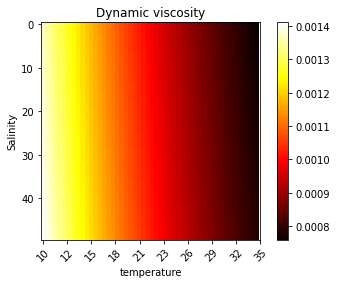

In [ ]:
counts = 50
comb_array = np.array(np.meshgrid(np.linspace(25, 40, counts )*10**(-3), np.linspace(10, 35, counts))).T.reshape(-1, 2)

comb_array

res = dynamic_viscosity(comb_array[:,0], comb_array[:,1]).reshape(counts,counts)

plt.imshow(res, cmap = 'hot')
plt.colorbar()
plt.title("Dynamic viscosity")
plt.ylabel('Salinity')
plt.xticks(np.linspace(0, 50, 10 ) ,np.linspace(25, 40, 10).astype(int), rotation=  45)
plt.xticks(np.linspace(0, 50, 10 ) ,np.linspace(10, 35, 10).astype(int), rotation=  45)
plt.xlabel('temperature')

### Kinamatic viscosity

$$v = \frac{\mu_{SW}}{\rho},$$ where $\mu_{SW}$ is the dynamic viscosity the seawater, and $\rho$ is the density of the water

In [ ]:
#| export
def kinamatic_visocity_fn(dynamic_viscosity:float = 1.18e-3, #This value is typically 1.18e-3 [kg/(ms)]
                          water_density:float = 1026 #The density of water under current conditions [kg/m^3]
                         )-> float: #[m^2/s]
    
    "A simple wrapper calculating the ratio of dynamic viscosity and water density"
    
    return dynamic_viscosity/water_density
    

The kinamatic viscosity can be calculated without entering any parameters, this uses the default values only

In [ ]:
kinamatic_visocity_fn()

1.1500974658869397e-06

However if the water conditions are not those of the default these alternative values can be entered as required

In [ ]:
dynamic_visc = 1.18e-3
water_density  = 1050
kinamatic_visocity_fn(dynamic_visc, water_density)


1.1238095238095239e-06

In [ ]:
#| hide
test_eq(kinamatic_visocity_fn(dynamic_visc, water_density)*water_density, 1.18e-3)


## Reynolds number
The reynolds number is a common formalua used throughout physiscs and engineering desciplines. Low reynolds numbers typically indicate laminar flow whilst high reynolds numbers typically indicate turbulent flow. However, in the case of ships the Reynolds number will always be large, however it is still a valuable component of many other calculations used by marine architects.


$$\text{Re} = \frac{V_s L_{os}}{v}, $$ where $V_s$ is the speed through wataer, $L_{os}$ is the length overall submerged of the ship, and $v$ is the kinamatic viscosity.

In [ ]:
#| export
def reynolds_number_fn(stw:float, #Speed through water [m/s]
                      length:float, #Length of the vessel, $L_{os}$ Length overall submerged is typically used [m]
                      kinamatic_viscosity:float # [m^2/s]
                      )->float: # Reynolds number is dimensionless
    
    "The Reynolds number is a element of fluid dynamics and is often used to predict whether flow is laminar or turbulent"
    
    return stw * length / kinamatic_viscosity
    
    

As can be seen due to the small values of kinamatic viscosity even a small ship going relatively slowly (approx 10kn) has a large reynolds number

In [ ]:
reynolds_number_fn(5, 50, 1.13e-6)

221238938.05309734

In [ ]:
#| hide
#Just checks nothing crazy has happened
test_eq(reynolds_number_fn(20, 50, 10),100)

## Froude Number

The ratio of flow inertia to an external field. The Froude number is often used in estimating the resistance of a partially submerged object in water

$$\text{Fr} = \frac{V_s}{g L_{WL}}, $$ where $V_S$ is the speed through water, $L_{WL}$ is the length at waterline, and $g$ is acceleration due to gravity.


In [ ]:
#| export

def froude_number_fn(stw:float, #speed through water [m/s]
                    length:float,#Length of vessel, typically $L_{wl}$ Length of waterline [m]
                    gravity:float = 9.81 #acceleration due to gravity [m/s^2]
                    )-> float : #The Froude number is a dimensionless value
    
    "The Froude number is useful for calculating the water resistance"
    
    return stw/np.sqrt(gravity * length)

As the Froude number is inversevly proportional to the size of the vessel, froude numbers tend to be small for ships which also tend to go at slower speeds.
Relative to the Reynolds number the Froude number is always much smaller.

In [ ]:
froude_number_fn(10, 50)

0.4515236409857309

In [ ]:
#| hide

#what tests could be useful here?

## Frictional resistance coefficent

The resistance coefficient related to the resistance of the water flowing over the hull


In [ ]:
#| export
def CF_fn(reynolds_number:float, #indicating the type of flow of the water
       adjustment_value:float = 0.1194 # An adjustment value applied by testing company. Default if from ITTC 57
      )-> float: #This is a dimensionaless value
    
    "An essential part of calculating the resistance experienced by the ship"
    
    return (1 + adjustment_value) * 0.067 / (np.log10(reynolds_number) -2) ** 2   
    

In [ ]:
CF_fn(1e6)

0.0046874875

In [ ]:
#| hide

test_eq(CF_fn(1e6, 0), 0.0041875)

## Roughness allowence

The 19$^{th}$ ITTC proposed a formula that corrects for the roughness of the vessel hull. 

$$\Delta C_F = \frac{11}{250} \left(  \left(\frac{k_s}{L_{WL}}\right)^{\frac{1}{3}} -10 \cdot \text{Re}^{-\frac{1}{3}} + \frac{1}{8000} \right), $$ wehere $k_s$ is the surface roughness, $L_{WL}$ is the length of vessel at waterline, and $Re$ is the Reynolds number for current conditions.

This value is used in several other adjustments and calculations. Function for obtaining it is found here.

In [ ]:
#| export
def roughness_allowence_fn(
                          length:float, #Length of the vessel at waterline [m]
                          reynolds_number:float, # dimensionless value describing flow properties
                          surface_roughness:float = 150e-6, #The default value is outdated an modern hull covering are likely considerably less rough [m]
                          )-> float: #
    
    ratio_value = surface_roughness / length
    return (11/250)* (ratio_value**(1/3) - 10 * reynolds_number**(-1/3)) + (1/8e3)
    

In [ ]:
roughness_allowence_fn(189, 2.63e9)

0.00021361371568178405

In [ ]:
#| hide

#I have no idea what is a reasonable value here so would require some input

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()